In [2]:
! pip install kaggle

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content'
# !chmod 600 /content/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:20<00:00, 211MB/s]
100% 2.29G/2.29G [00:20<00:00, 122MB/s]


In [5]:
!unzip chest-xray-pneumonia.zip -d chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0442-

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.models import *
from keras.layers import *
from numpy import argmax
from sklearn.metrics import accuracy_score,  confusion_matrix
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,)
test_datagen = ImageDataGenerator(rescale=1./255,)
val_datagen = ImageDataGenerator(rescale=1./255,)

In [8]:
train_set = train_datagen.flow_from_directory(
    '/content/chest-xray-pneumonia/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    # class_mode='binary', # defualt is multiclssificatoin(categorical)
    shuffle=False
)

Found 5216 images belonging to 2 classes.


In [9]:
test_set = test_datagen.flow_from_directory(
    '/content/chest-xray-pneumonia/chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    # class_mode='binary', # defualt is multiclssificatoin(categorical)
    shuffle=False
)

Found 624 images belonging to 2 classes.


In [10]:
val_set = val_datagen.flow_from_directory(
    '/content/chest-xray-pneumonia/chest_xray/val',
    target_size=(224, 224),
    batch_size=32,
    # class_mode='binary', # defualt is multiclssificatoin(categorical)
    shuffle=False
)

Found 16 images belonging to 2 classes.


In [11]:
vgg16_model=vgg16.VGG16(include_top=False, input_shape=(224, 224, 3))
# Freeze all the layers

for layer in vgg16_model.layers[:]:

    layer.trainable = False

vgg16_model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [12]:
model = Sequential()
model.add(vgg16_model)
model.add(Flatten(name='flatten'))
model.add(Dense(1024, activation='relu', name='fc1'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax', name='output'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 fc1 (Dense)                 (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 output (Dense)              (None, 2)                 2050      
                                                                 
Total params: 40407874 (154.14 MB)
Trainable params: 25693186 (98.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [13]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer="sgd", metrics=['accuracy'])
model.fit( train_set,
          epochs=10,
           validation_data=val_set,
           steps_per_epoch=len(train_set),
           validation_steps=len(val_set),
           callbacks=tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True))

Epoch 1/10
163/163 [==============================] - 81s 408ms/step - loss: 0.9624 - accuracy: 0.7435 - val_loss: 0.8989 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 60s 370ms/step - loss: 0.6114 - accuracy: 0.7306 - val_loss: 0.5800 - val_accuracy: 0.8750
Epoch 3/10
163/163 [==============================] - 62s 379ms/step - loss: 0.5549 - accuracy: 0.7483 - val_loss: 0.6544 - val_accuracy: 0.5625
Epoch 4/10
163/163 [==============================] - 57s 350ms/step - loss: 0.4107 - accuracy: 0.8209 - val_loss: 1.2096 - val_accuracy: 0.5000
Epoch 5/10
163/163 [==============================] - 59s 362ms/step - loss: 0.3524 - accuracy: 0.8537 - val_loss: 0.5889 - val_accuracy: 0.6875


In [14]:
score = model.evaluate(test_set)

20/20 [==============================] - 6s 271ms/step - loss: 0.5868 - accuracy: 0.8301


In [15]:
# prediction of our data
y_pred=model.predict(test_set)
y_pred.shape

163/163 [==============================] - 58s 353ms/step


(5216, 2)

In [16]:
y_pred1=argmax(y_pred,axis=1)
y_pred1.shape

(5216,)

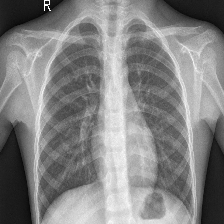

In [17]:
img =load_img('/content/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg',target_size =(224,224))
img

In [18]:
img1 =img_to_array(img)
img1.shape

(224, 224, 3)

In [19]:
img1 = img1/255
img1 =np.expand_dims(test_set[0][0][0], axis =0)
img1.shape

(1, 224, 224, 3)

In [20]:
np.argmax(model.predict(img1),axis=1)

1/1 [==============================] - 1s 836ms/step


array([0])